# initialization

In [ ]:
!pip install geojson
!pip install geopandas

In [ ]:
!pip install geemap
import geemap
import geemap.chart as chart
import folium

In [ ]:
import os
import geemap
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Zc0Y-yHQVI8-0aF6oOtLwF1YdvVTRoT0SNMfGxRkYEs&tc=ua-yczqlqwiIhZx4dqq7r2FNF1xCXtghSUf3SP_sw0c&cc=O0in0NzfPUKaws6xi24h1PW1-8KdH6q-at3-SVQ8rKo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BXiC8_xJ3lCx6QYOjphY58sG1oI8h-vFZxYuWEZY_XEU9POs40Z-5c

Successfully saved authorization token.


In [ ]:
import json
import pandas as pd

try:
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import altair as alt
import numpy as np
import folium
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
import geopandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Loerstan_DeclineOrder = geopandas.read_file('path to /DeclineOrder_wgs84.shp')

In [ ]:
def ee_reducer(ee_collection, region):

  reduce_ee_collection = create_reduce_region_function(
      geometry = region, reducer=ee.Reducer.mean(), scale=5000)

  ee_collection_stat_fc = ee.FeatureCollection(ee_collection.map(reduce_ee_collection)).filter(
      ee.Filter.notNull(ee_collection.first().bandNames()))

  # Define a function to transfer feature properties to a dictionary.
  def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
        reducer=ee.Reducer.toList().repeat(prop_names.size()),
        selectors=prop_names).get('list')

    return ee.Dictionary.fromLists(prop_names, prop_lists)

  ee_collection_dict = fc_to_dict(ee_collection_stat_fc).getInfo()

  reduced_ee_collection_df = pd.DataFrame(ee_collection_dict)

  def add_date_info(df):
    df['millis'] = df['millis']
    df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    return df

  reduced_ee_collection_df = add_date_info(reduced_ee_collection_df)

  reduced_ee_collection_df = reduced_ee_collection_df.rename(columns={
      'ee_collection': 'ee_collection'
  })

  reduced_ee_collection_df = reduced_ee_collection_df.rename(columns={
    'pdsi': 'PDSI'
  })

  return reduced_ee_collection_df

In [ ]:
import json


js = json.loads(Loerstan_DeclineOrder.to_json())
geometry_all_decline_order = ee.Geometry(ee.FeatureCollection(js).geometry())


In [ ]:
D1 = Loerstan_DeclineOrder.drop([1, 2, 3, 4])
js = json.loads(D1.to_json())
D1_geometry = ee.Geometry(ee.FeatureCollection(js).geometry())

D2 = Loerstan_DeclineOrder.drop([0, 2, 3, 4])
D2 = D2.reset_index()
js = json.loads(D2.to_json())
D2_geometry = ee.Geometry(ee.FeatureCollection(js).geometry())

D3 = Loerstan_DeclineOrder.drop([1, 0, 3, 4])
D3 = D3.reset_index()
js = json.loads(D3.to_json())
D3_geometry = ee.Geometry(ee.FeatureCollection(js).geometry())

D4 = Loerstan_DeclineOrder.drop([1, 2, 0, 4])
D4 = D4.reset_index()
js = json.loads(D4.to_json())
D4_geometry = ee.Geometry(ee.FeatureCollection(js).geometry())

D5 = Loerstan_DeclineOrder.drop([1, 2, 3, 0])
D5 = D5.reset_index()
js = json.loads(D5.to_json())
D5_geometry = ee.Geometry(ee.FeatureCollection(js).geometry())

## PDSI

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

pdsi_visualization = {
  'min': -100,
  'max': 100,
  };
#Map.centerObject(geometry_all_decline_order, 8)
#Map.addLayer(pdsi, pdsi_visualization, "pdsi")
#Map.addLayer(geometry_all_decline_order)
#Map

In [ ]:
region = geometry_all_decline_order
ee_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date('1950-01-01', '2023-04-06')).filterBounds(region)

teraClimate_all = ee_reducer(ee_collection, region)

#teraClimate_all.to_csv('/content/drive/My Drive/earthengine/results/lorestan/TERRACLIMATE_aras.csv')

teraClimate_all.head(1)

In [ ]:
alt.Chart(teraClimate_all).mark_rect().encode(
    x='Year:O',
    y='Month:O',
    color=alt.Color(
        'mean(PDSI):Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:O', title='Month'),
        alt.Tooltip('mean(PDSI)', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
alt.Chart(teraClimate_all).mark_bar(size=1).encode(
    x='Timestamp:T',
    y='PDSI',
    color=alt.Color(
        'PDSI:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Date'),
        alt.Tooltip('PDSI:Q', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

### Region 1


In [ ]:
region = D1_geometry

ee_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date('1950-01-01', '2023-04-06')).filterBounds(region)

teraClimate_R1 = ee_reducer(ee_collection, region)

#teraClimate_R1.to_csv('/content/drive/My Drive/earthengine/results/lorestan/TERRACLIMATE_R1.csv')

teraClimate_R1.head(1)

aet  def        millis        PDSI         pet         pr  \
0  229.390186  0.0 -378691200000 -145.372295  250.124938  62.817829   

          ro        soil        srad        swe  ...       tmmn       tmmx  \
0  17.867208  568.366005  1062.23933  21.714243  ... -25.935682  86.682928   

          vap        vpd          vs  Timestamp  Year  Month  Day  DOY  
0  542.767543  29.801203  148.549119 1958-01-01  1958      1    1    1  

[1 rows x 21 columns]

In [ ]:
teraClimate_R1['PDSI'] = teraClimate_R1['PDSI'] * 0.01

In [ ]:
alt.Chart(teraClimate_R1).mark_rect().encode(
    x='Year:O',
    y='Month:O',
    color=alt.Color(
        'mean(PDSI):Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:O', title='Month'),
        alt.Tooltip('mean(PDSI)', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
alt.Chart(teraClimate_R1).mark_bar(size=1).encode(
    x='Timestamp:T',
    y='PDSI',
    color=alt.Color(
        'PDSI:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Date'),
        alt.Tooltip('PDSI:Q', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

### Region 2


In [ ]:
region = D2_geometry

ee_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date('1950-01-01', '2023-04-06')).filterBounds(region)

teraClimate_R2 = ee_reducer(ee_collection, region)

#teraClimate_R2.to_csv('/content/drive/My Drive/earthengine/results/lorestan/TERRACLIMATE_R2.csv')

teraClimate_R2['PDSI'] = teraClimate_R2['PDSI'] * 0.01

#Map = geemap.Map()
#Map.add_basemap('HYBRID')

pdsi_visualization = {
  'min': -100,
  'max': 100,
  };
#Map.centerObject(D2_geometry, 6)
#Map.addLayer(pdsi, pdsi_visualization, "pdsi")
#Map.addLayer(D2_geometry)
#Map

teraClimate_R2.head(1)

aet  def        millis      PDSI         pet         pr         ro  \
0  363.351484  0.0 -378691200000 -1.735785  378.796312  69.724549  25.266089   

         soil         srad       swe  ...      tmmn        tmmx         vap  \
0  657.566953  1046.384202  5.909486  ... -1.364062  109.234657  550.809944   

         vpd          vs  Timestamp  Year  Month  Day  DOY  
0  42.515381  166.596584 1958-01-01  1958      1    1    1  

[1 rows x 21 columns]

In [ ]:
teraClimate_R2['PDSI'] = teraClimate_R2['PDSI'] * 0.01


In [ ]:
alt.Chart(teraClimate_R2).mark_rect().encode(
    x='Year:O',
    y='Month:O',
    color=alt.Color(
        'mean(PDSI):Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:O', title='Month'),
        alt.Tooltip('mean(PDSI)', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
alt.Chart(teraClimate_R2).mark_bar(size=1).encode(
    x='Timestamp:T',
    y='PDSI',
    color=alt.Color(
        'PDSI:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Date'),
        alt.Tooltip('PDSI:Q', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

### Region 3


In [ ]:
region = D3_geometry

ee_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date('1950-01-01', '2023-04-06')).filterBounds(region)

teraClimate_R3 = ee_reducer(ee_collection, region)

#teraClimate_R3.to_csv('/content/drive/My Drive/earthengine/results/lorestan/TERRACLIMATE_R3.csv')

teraClimate_R3['PDSI'] = teraClimate_R3['PDSI'] * 0.01


#Map = geemap.Map()
#Map.add_basemap('HYBRID')

pdsi_visualization = {
  'min': -100,
  'max': 100,
  };
#Map.centerObject(D2_geometry, 6)
#Map.addLayer(pdsi, pdsi_visualization, "pdsi")
#Map.addLayer(D2_geometry)
#Map

teraClimate_R3.head(1)

aet  def        millis      PDSI         pet         pr         ro  \
0  484.207689  0.0 -378691200000 -1.854522  485.580632  73.245594  22.611014   

         soil        srad       swe  ...       tmmn        tmmx         vap  \
0  639.018994  1060.61729  0.036783  ...  24.848504  136.190939  613.172236   

         vpd          vs  Timestamp  Year  Month  Day  DOY  
0  54.116459  185.079177 1958-01-01  1958      1    1    1  

[1 rows x 21 columns]

In [ ]:
alt.Chart(teraClimate_R3).mark_rect().encode(
    x='Year:O',
    y='Month:O',
    color=alt.Color(
        'mean(PDSI):Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:O', title='Month'),
        alt.Tooltip('mean(PDSI)', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
alt.Chart(teraClimate_R3).mark_bar(size=1).encode(
    x='Timestamp:T',
    y='PDSI',
    color=alt.Color(
        'PDSI:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Date'),
        alt.Tooltip('PDSI:Q', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

### Region 4



In [ ]:
region = D4_geometry

ee_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date('1950-01-01', '2023-04-06')).filterBounds(region)

teraClimate_R4 = ee_reducer(ee_collection, region)

#teraClimate_R4.to_csv('/content/drive/My Drive/earthengine/results/lorestan/TERRACLIMATE_R4.csv')

teraClimate_R4['PDSI'] = teraClimate_R4['PDSI'] * 0.01


#Map = geemap.Map()
#Map.add_basemap('HYBRID')

pdsi_visualization = {
  'min': -100,
  'max': 100,
  };
#Map.centerObject(D4_geometry, 6)
#Map.addLayer(pdsi, pdsi_visualization, "pdsi")
#Map.addLayer(D4_geometry)
#Map

teraClimate_R4.head(1)

aet  def        millis      PDSI        pet         pr         ro  \
0  495.074437  0.0 -378691200000 -1.817381  495.31376  74.982206  24.122776   

         soil         srad  swe  ...       tmmn        tmmx         vap  \
0  660.967378  1059.739917  0.0  ...  29.627817  141.389383  642.810202   

         vpd          vs  Timestamp  Year  Month  Day  DOY  
0  54.783215  190.274318 1958-01-01  1958      1    1    1  

[1 rows x 21 columns]

In [ ]:
alt.Chart(teraClimate_R4).mark_rect().encode(
    x='Year:O',
    y='Month:O',
    color=alt.Color(
        'mean(PDSI):Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:O', title='Month'),
        alt.Tooltip('mean(PDSI)', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
alt.Chart(teraClimate_R4).mark_bar(size=1).encode(
    x='Timestamp:T',
    y='PDSI',
    color=alt.Color(
        'PDSI:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Date'),
        alt.Tooltip('PDSI:Q', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

### Region 5



In [ ]:
region = D5_geometry

ee_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date('1950-01-01', '2023-04-06')).filterBounds(region)

teraClimate_R5 = ee_reducer(ee_collection, region)

#teraClimate_R5.to_csv('/content/drive/My Drive/earthengine/results/lorestan/TERRACLIMATE_R5.csv')
teraClimate_R5['PDSI'] = teraClimate_R5['PDSI'] * 0.01



Map = geemap.Map()
Map.add_basemap('HYBRID')

pdsi_visualization = {
  'min': -100,
  'max': 100,
  };
Map.centerObject(D5_geometry, 6)
Map.addLayer(ee_collection, pdsi_visualization, "PDSI")
Map.addLayer(D5_geometry)
Map

#teraClimate_R5.head(1)

In [ ]:
alt.Chart(teraClimate_R5).mark_rect().encode(
    x='Year:O',
    y='Month:O',
    color=alt.Color(
        'mean(PDSI):Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:O', title='Month'),
        alt.Tooltip('mean(PDSI)', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
alt.Chart(teraClimate_R5).mark_bar(size=1).encode(
    x='Timestamp:T',
    y='PDSI',
    color=alt.Color(
        'PDSI:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Date'),
        alt.Tooltip('PDSI:Q', title='PDSI')
    ]).properties(width=600, height=300)

alt.Chart(...)

In [ ]:
teraClimate_R5.head(1)

aet  def        millis     PDSI         pet         pr         ro  \
0  488.189159  0.0 -378691200000 -183.375  489.036504  73.199853  24.257006   

         soil         srad  swe  ...       tmmn        tmmx         vap  \
0  564.112094  1061.265118  0.0  ...  30.057153  141.007375  648.112094   

         vpd          vs  Timestamp  Year  Month  Day  DOY  
0  54.490413  187.897124 1958-01-01  1958      1    1    1  

[1 rows x 21 columns]

### Summary PDSI

In [ ]:
pdsi = pd.DataFrame()
pdsi['all'] = Terra_df_all_regions['vs']
pdsi['R1'] = pdsi_df_R1['vs']
pdsi['R2'] = pdsi_df_R2['vs']
pdsi['R3'] = pdsi_df_R3['vs']
pdsi['R4'] = pdsi_df_R4['vs']
pdsi['R5'] = pdsi_df_R5['vs']
pdsi.plot.line(figsize=(20, 5))

## Totpographic Diversity

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
ee_image = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity')

td_all = ee_image.clip(geometry_all_decline_order)
td_R1 = ee_image.clip(D1_geometry)
td_R2 = ee_image.clip(D2_geometry)
td_R3 = ee_image.clip(D3_geometry)
td_R4 = ee_image.clip(D4_geometry)
td_R5 = ee_image.clip(D5_geometry)


"""
visualization = {
  'min': 0,
  'max': 1,

  };
Map = geemap.Map()
#Map.add_basemap('HYBRID')

Map.centerObject(geometry_all_decline_order, 6)
Map.addLayer(td_all, visualization, "LAI")
Map.addLayer(geometry_all_decline_order)
Map
"""

'\nvisualization = {\n  \'min\': 0,\n  \'max\': 1,\n\n  };\nMap = geemap.Map()\n#Map.add_basemap(\'HYBRID\')\n\nMap.centerObject(geometry_all_decline_order, 6)\nMap.addLayer(td_all, visualization, "LAI")\nMap.addLayer(geometry_all_decline_order)\nMap\n'

In [ ]:
def image_hist(image, region, name):

  histogramDictionary = image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
  })
  # print(histogramDictionary.getInfo())

  histogram = histogramDictionary.getInfo()
  bands = list(histogram.keys())
  #bands


  for bnd in bands:
      # plot a bar chart

      y=histogram[bnd]['histogram']
      x=[]
      for i in range(len(y)):
          x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
      data = pd.DataFrame({'x':x,
                              'y':y})

      # Draw Plot
      fig, ax = plt.subplots(figsize=(25, 7), dpi=80)

      sns.barplot(
          data= data,
          color = 'gray',
          x= 'x',
          y= 'y',
          ax=ax
      )
      # For every axis, set the x and y major locator
      ax.xaxis.set_major_locator(plt.MaxNLocator(10))


      # Adjust width gap to zero
      for patch in ax.patches:
          current_height = patch.get_width()
          patch.set_width(1)
          patch.set_y(patch.get_y() + current_height - 1)

      # figure label and title
      #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
      plt.ylabel('Frequency (in power 10)', fontsize=22)
      plt.xlabel('Topographic diversity (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=22)
      # save the fihure as JPG file

      ax.tick_params(axis='both', labelsize=22)
      ax.tick_params(axis='both', labelsize=22)
      fig.savefig('fig-{}.jpg'.format(name),  format="jpg", dpi=600)


      #plt.savefig("Slope_hist_R1.jpg", format="jpg", dpi=600)

      hist_df = pd.DataFrame()
      hist_df['x'] = x
      hist_df['y'] = y

      return hist_df

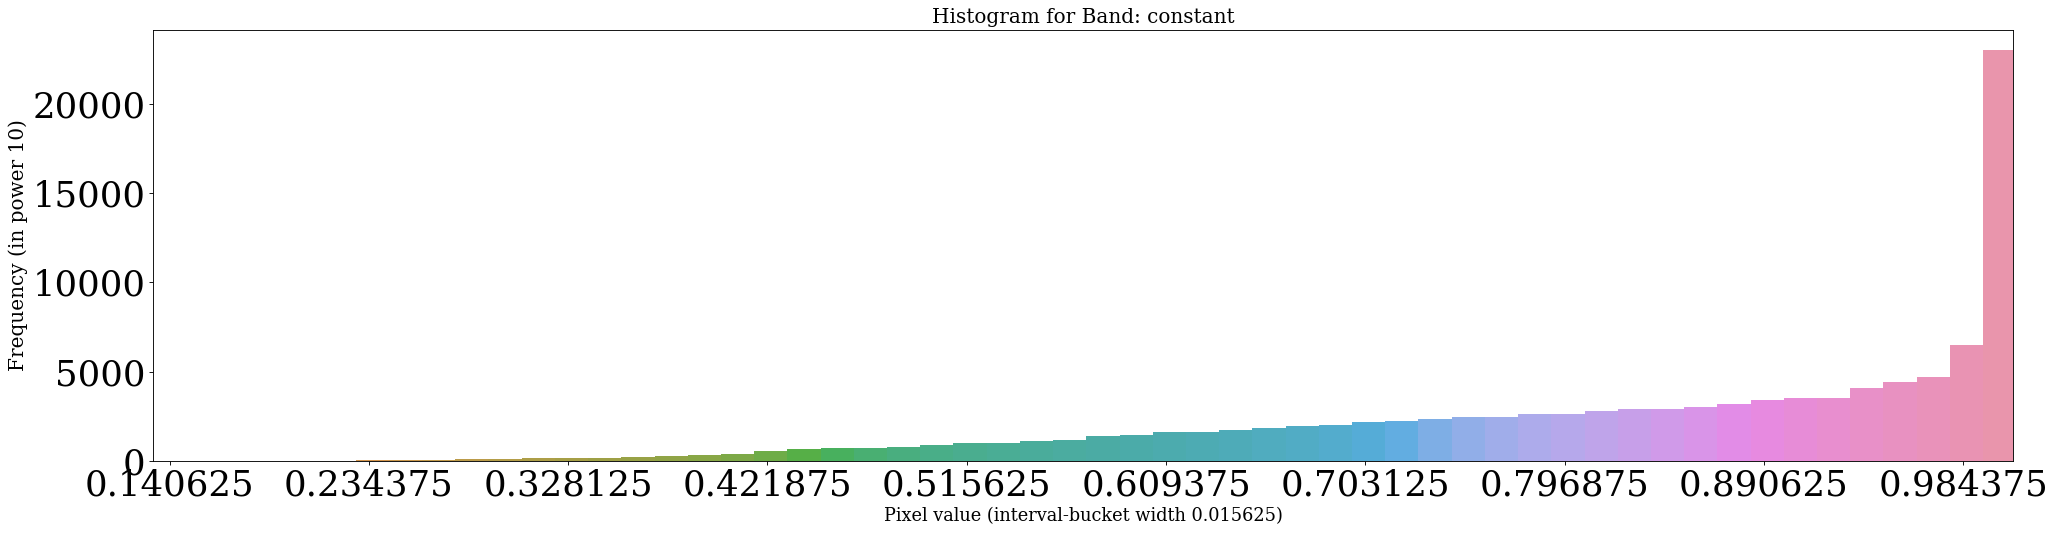

In [ ]:
region = D1_geometry
ee_image = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=18)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=16)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

SRTM_topoDiversity_df_R1 = pd.DataFrame()
SRTM_topoDiversity_df_R1['R1_x'] = x
SRTM_topoDiversity_df_R1['Region 1'] = y

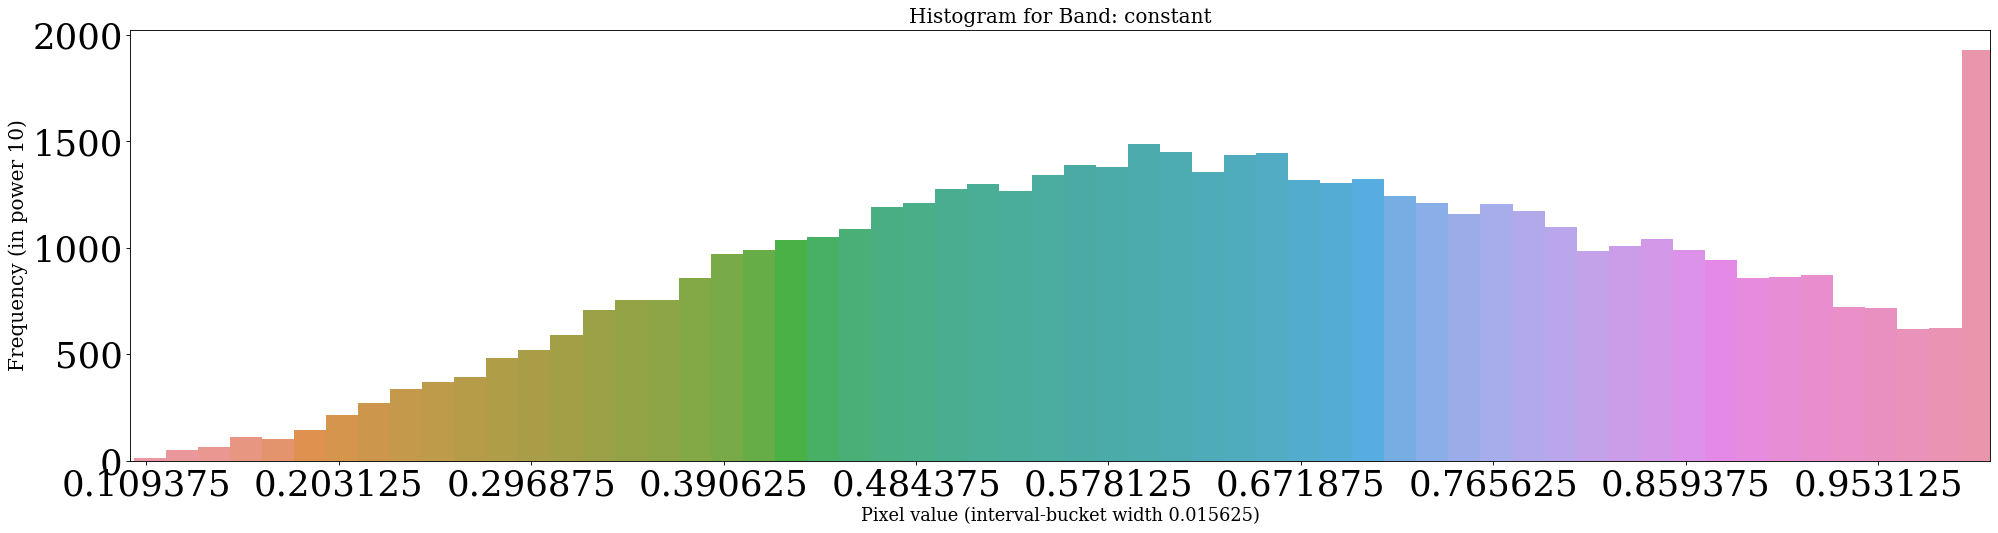

In [ ]:
region = D2_geometry
ee_image = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=18)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=16)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

SRTM_topoDiversity_df_R2 = pd.DataFrame()
SRTM_topoDiversity_df_R2['R2_x'] = x
SRTM_topoDiversity_df_R2['Region 2'] = y

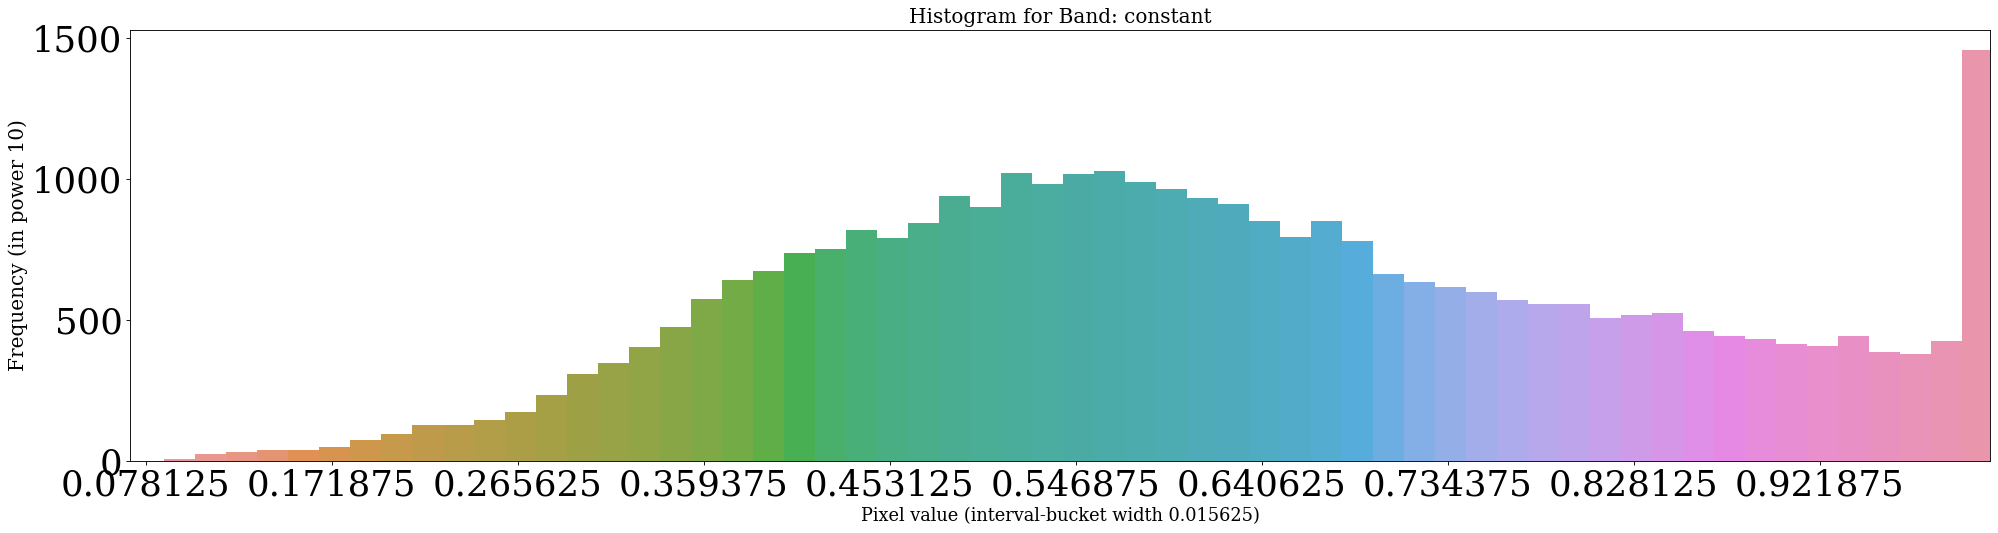

In [ ]:
region = D3_geometry
ee_image = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=18)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=16)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

SRTM_topoDiversity_df_R3 = pd.DataFrame()
SRTM_topoDiversity_df_R3['R3_x'] = x
SRTM_topoDiversity_df_R3['Region 3'] = y

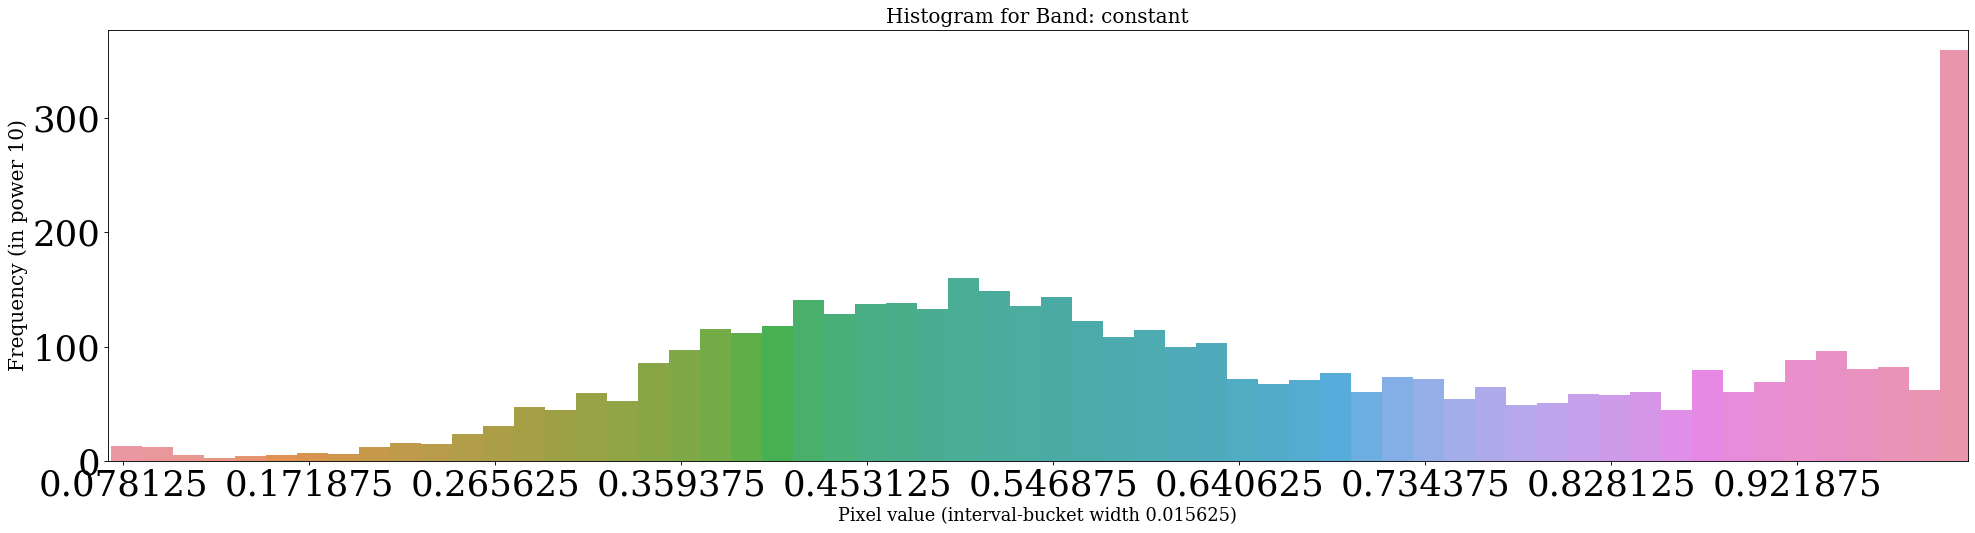

In [ ]:
region = D4_geometry
ee_image = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
 # 'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=18)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=16)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

SRTM_topoDiversity_df_R4 = pd.DataFrame()
SRTM_topoDiversity_df_R4['R4_x'] = x
SRTM_topoDiversity_df_R4['Region 4'] = y

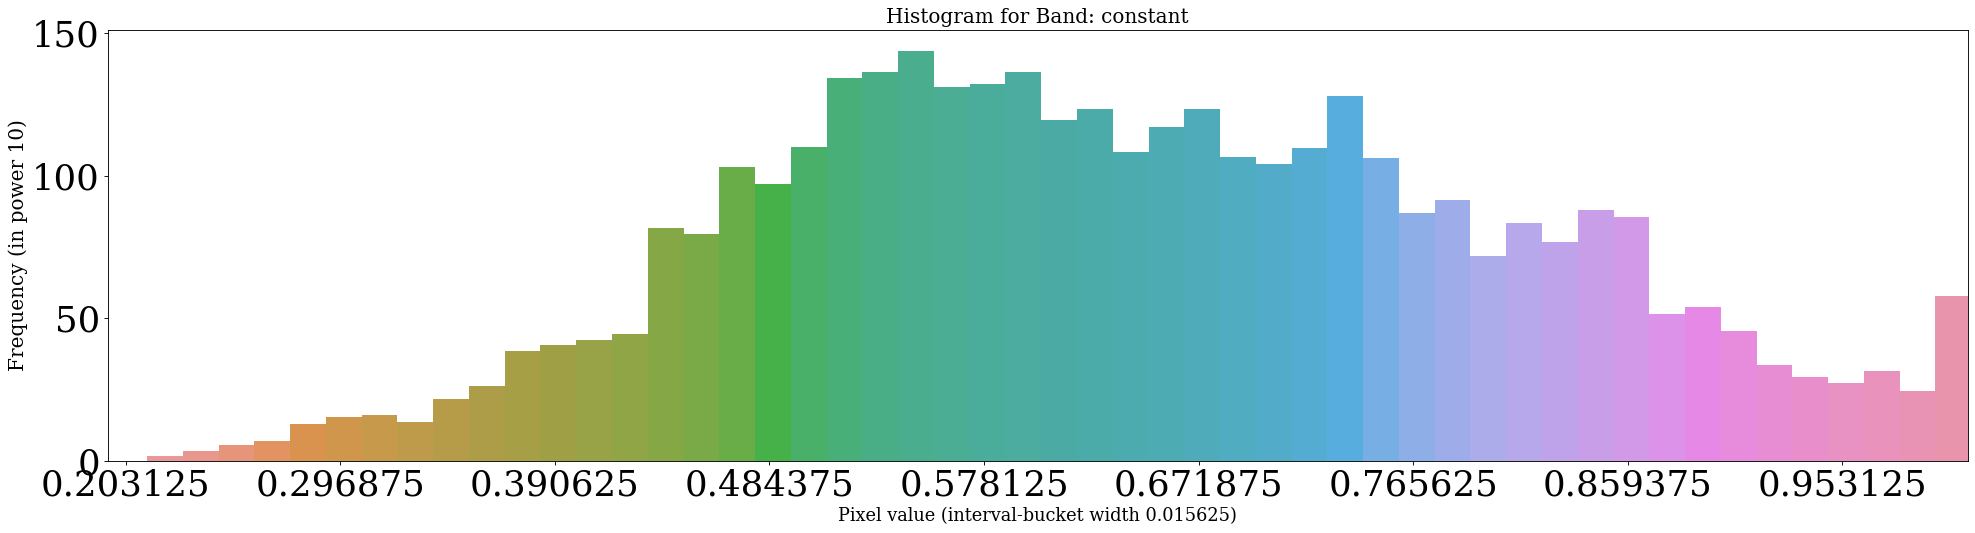

In [ ]:
region = D5_geometry
ee_image = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=18)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=16)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

SRTM_topoDiversity_df_R5 = pd.DataFrame()
SRTM_topoDiversity_df_R5['R5_x'] = x
SRTM_topoDiversity_df_R5['Region 5'] = y

In [ ]:
ax = hist_df_R1.plot(x = 'x', y= 'y_R1', figsize=(15, 4))
#hist_df_R1.plot(ax=ax, x = 'x', y= 'y_R1', figsize=(15, 4))
hist_df_R2.plot(ax=ax, x = 'x', y= 'y_R2', figsize=(15, 4))
hist_df_R3.plot(ax=ax, x = 'x', y= 'y_R3', figsize=(15, 4))
hist_df_R4.plot(ax=ax, x = 'x', y= 'y_R4', figsize=(15, 4))
hist_df_R5.plot(ax=ax, x = 'x', y= 'y_R5', figsize=(15, 4))

## Height

In [ ]:
region = D1_geometry
ee_image = ee.Image('CGIAR/SRTM90_V4')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(100),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(25, 8), dpi=600)

    sns.barplot(
        data= data,
        color = "gray",
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))

    ax.tick_params(axis='both', labelsize=18)
    ax.tick_params(axis='both', labelsize=18)


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    font = {'fontname':'monospace'}
    #plt.title('Histogram for {}'.format(bnd), fontsize=18)
    plt.ylabel('\n Frequency (in power 10)', **font,  fontsize=20)
    plt.xlabel('\n Height value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=20)
    ax.tick_params(axis='both', labelsize=22)
    ax.tick_params(axis='both', labelsize=22)

    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)
plt.savefig("Height_hist_R1.jpg", format="jpg", dpi=600)

SRTM_Dem_df_R1 = pd.DataFrame()
SRTM_Dem_df_R1['R1_x'] = x
SRTM_Dem_df_R1['R1_y'] = y

In [ ]:
region = D2_geometry
ee_image = ee.Image('CGIAR/SRTM90_V4')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(100),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=600)

    sns.barplot(
        data= data,
        color = "gray",
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=22)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=22)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)
plt.savefig("Height_hist_R2.jpg", format="jpg", dpi=600)

SRTM_Dem_df_R2 = pd.DataFrame()
SRTM_Dem_df_R2['R2_x'] = x
SRTM_Dem_df_R2['R2_y'] = y

In [ ]:
region = D3_geometry
ee_image = ee.Image('CGIAR/SRTM90_V4')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(100),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=600)

    sns.barplot(
        data= data,
        color = "gray",
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=22)
    plt.ylabel('Frequency (in power 10)', fontsize=22)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=22)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)
plt.savefig("Height_hist_R3.jpg", format="jpg", dpi=600)

SRTM_Dem_df_R3 = pd.DataFrame()
SRTM_Dem_df_R3['R3_x'] = x
SRTM_Dem_df_R3['R3_y'] = y

In [ ]:
region = D4_geometry
ee_image = ee.Image('CGIAR/SRTM90_V4')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(100),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=600)

    sns.barplot(
        data= data,
        color = "gray",
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=22)
    plt.ylabel('Frequency (in power 10)', fontsize=12)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=22)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)
plt.savefig("Height_hist_R4.jpg", format="jpg", dpi=600)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)

SRTM_Dem_df_R4 = pd.DataFrame()
SRTM_Dem_df_R4['R4_x'] = x
SRTM_Dem_df_R4['R4_y'] = y

In [ ]:
region = D5_geometry
ee_image = ee.Image('CGIAR/SRTM90_V4')


histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(100),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=600)

    sns.barplot(
        data= data,
        color = "gray",
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=22)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=22)
    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)
plt.savefig("Height_hist_R5.jpg", format="jpg", dpi=600)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='both', labelsize=22)

SRTM_Dem_df_R5 = pd.DataFrame()
SRTM_Dem_df_R5['R5_x'] = x
SRTM_Dem_df_R5['R5_y'] = y

In [ ]:
SRTM_Dem_df_R11 = SRTM_Dem_df_R1
SRTM_Dem_df_R22 = SRTM_Dem_df_R2
SRTM_Dem_df_R33 = SRTM_Dem_df_R3
SRTM_Dem_df_R44 = SRTM_Dem_df_R4
SRTM_Dem_df_R55 = SRTM_Dem_df_R5

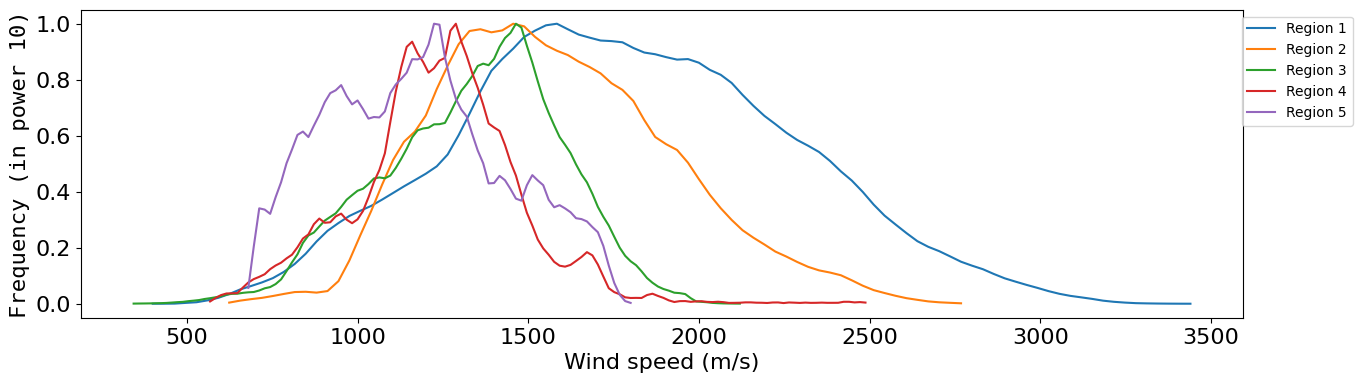

In [ ]:
SRTM_Dem_df_R1 = SRTM_Dem_df_R11
SRTM_Dem_df_R2 = SRTM_Dem_df_R22
SRTM_Dem_df_R3 = SRTM_Dem_df_R33
SRTM_Dem_df_R4 = SRTM_Dem_df_R44
SRTM_Dem_df_R5 = SRTM_Dem_df_R55

SRTM_Dem_df_R1 = SRTM_Dem_df_R1.rolling(window=2).mean()

SRTM_Dem_df_R2 = SRTM_Dem_df_R2.rolling(window=2).mean()

SRTM_Dem_df_R3 = SRTM_Dem_df_R3.rolling(window=2).mean()

SRTM_Dem_df_R4 = SRTM_Dem_df_R4.rolling(window=2).mean()

SRTM_Dem_df_R5 = SRTM_Dem_df_R5.rolling(window=2).mean()



SRTM_Dem_df_R1['R1_y'] = SRTM_Dem_df_R1['R1_y'] /SRTM_Dem_df_R1['R1_y'].abs().max()

SRTM_Dem_df_R2['R2_y'] = SRTM_Dem_df_R2['R2_y'] /SRTM_Dem_df_R2['R2_y'].abs().max()

SRTM_Dem_df_R3['R3_y'] = SRTM_Dem_df_R3['R3_y'] /SRTM_Dem_df_R3['R3_y'].abs().max()

SRTM_Dem_df_R4['R4_y'] = SRTM_Dem_df_R4['R4_y'] /SRTM_Dem_df_R4['R4_y'].abs().max()

SRTM_Dem_df_R5['R5_y'] = SRTM_Dem_df_R5['R5_y'] /SRTM_Dem_df_R5['R5_y'].abs().max()





ax = SRTM_Dem_df_R1.plot(x = 'R1_x', y= 'R1_y', figsize=(15, 4))
SRTM_Dem_df_R2.plot(ax=ax, x = 'R2_x', y= 'R2_y', figsize=(15, 4))
SRTM_Dem_df_R3.plot(ax=ax, x = 'R3_x', y= 'R3_y', figsize=(15, 4))
SRTM_Dem_df_R4.plot(ax=ax, x = 'R4_x', y= 'R4_y', figsize=(15, 4))
SRTM_Dem_df_R5.plot(ax=ax, x = 'R5_x', y= 'R5_y', figsize=(15, 4))

plt.legend(['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5'], loc='upper right', bbox_to_anchor=(1.1,1))

font = {'fontname':'monospace'}


plt.ylabel('Frequency (in power 10)', **font,  fontsize=16)
plt.xlabel("Wind speed (m/s)", fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='both', labelsize=16)





plt.savefig("normalized_height.jpg", format="jpg", dpi=600)

plt.show()


## Slope

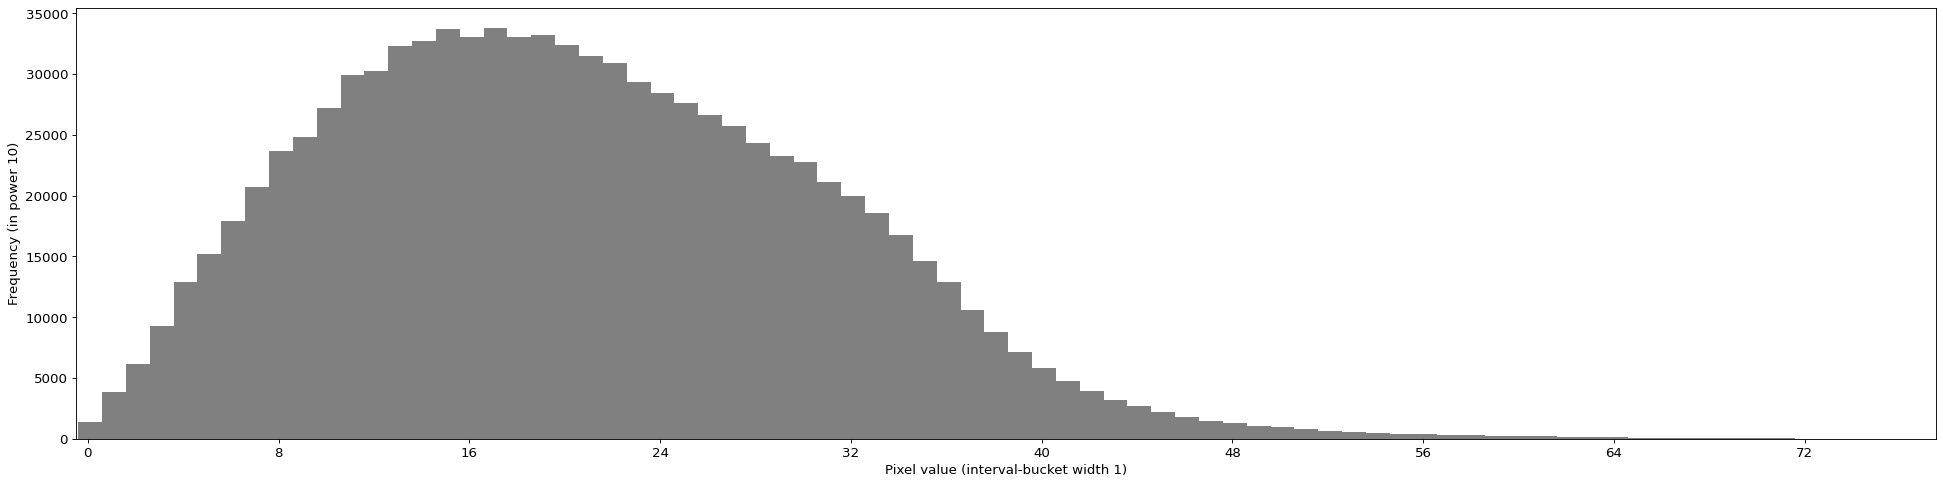

In [ ]:
region = D1_geometry
dem = ee.Image('CGIAR/SRTM90_V4')
ee_image = ee.Terrain.slope(dem)

histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(90),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        color= 'gray',
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=12)
    plt.ylabel('Frequency (in power 10)', fontsize=12)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='both', labelsize=12)

    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

plt.savefig("Slope_hist_R1.jpg", format="jpg", dpi=600)

SRTM_Slope_df_R1 = pd.DataFrame()
SRTM_Slope_df_R1['R1_x'] = x
SRTM_Slope_df_R1['R1_y'] = y

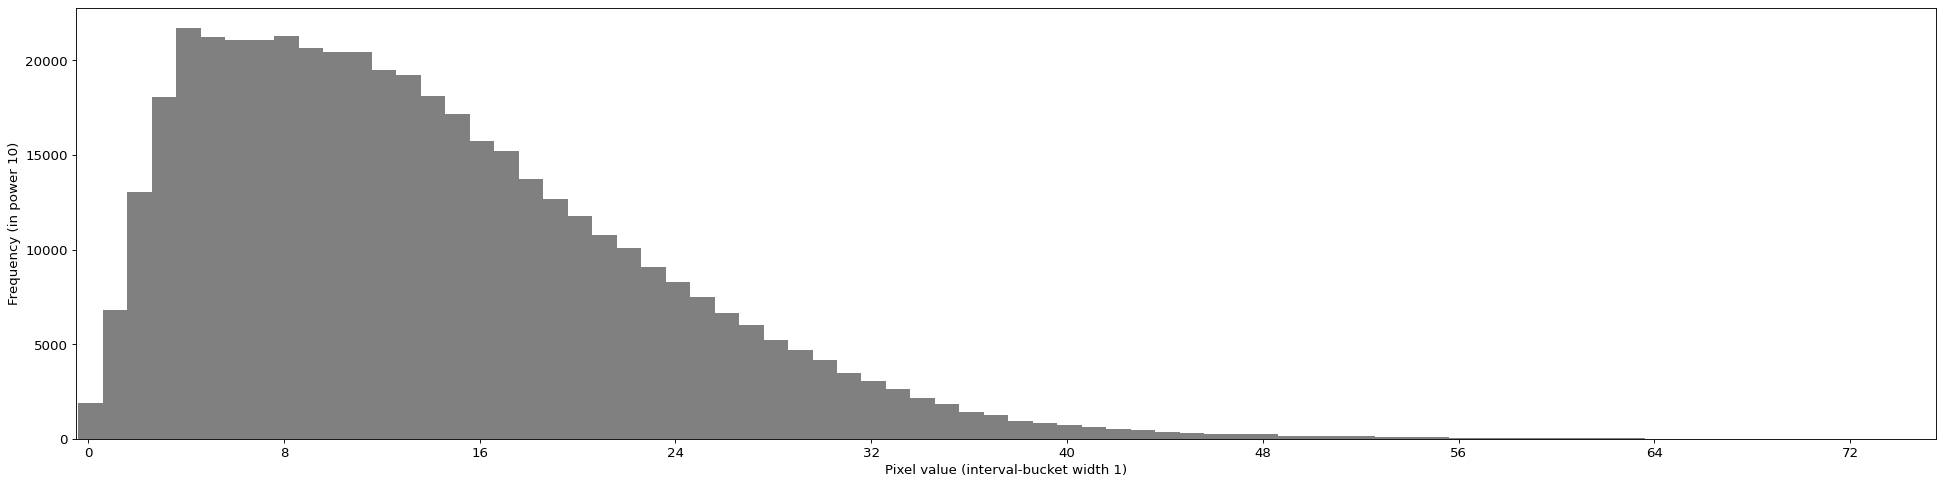

In [ ]:
region = D2_geometry
dem = ee.Image('CGIAR/SRTM90_V4')
ee_image = ee.Terrain.slope(dem)

histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(90),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        color= 'gray',
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=12)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='both', labelsize=12)

    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

plt.savefig("Slope_hist_R2.jpg", format="jpg", dpi=600)

SRTM_Slope_df_R2 = pd.DataFrame()
SRTM_Slope_df_R2['R2_x'] = x
SRTM_Slope_df_R2['R2_y'] = y

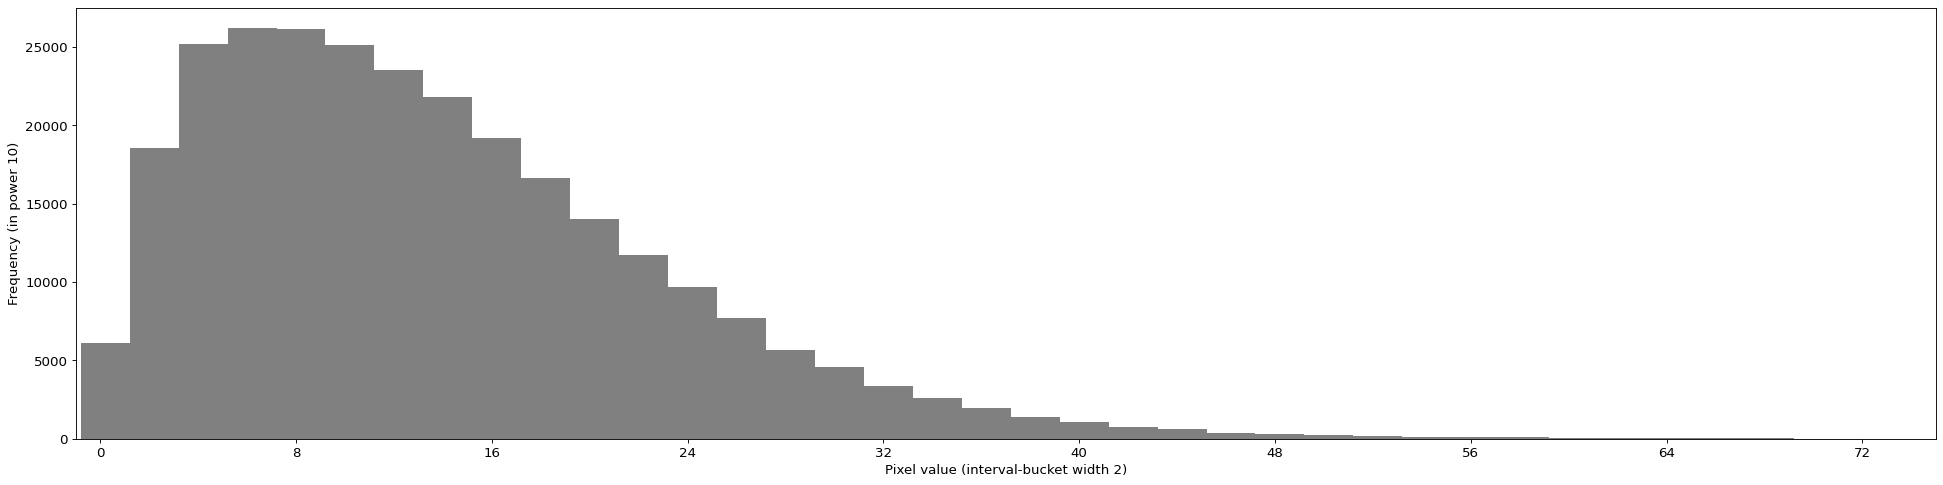

In [ ]:
region = D3_geometry
dem = ee.Image('CGIAR/SRTM90_V4')
ee_image = ee.Terrain.slope(dem)

histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        color= 'gray',
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=12)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='both', labelsize=12)

    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

plt.savefig("Slope_hist_R3.jpg", format="jpg", dpi=600)


SRTM_Slope_df_R3 = pd.DataFrame()
SRTM_Slope_df_R3['R3_x'] = x
SRTM_Slope_df_R3['R3_y'] = y

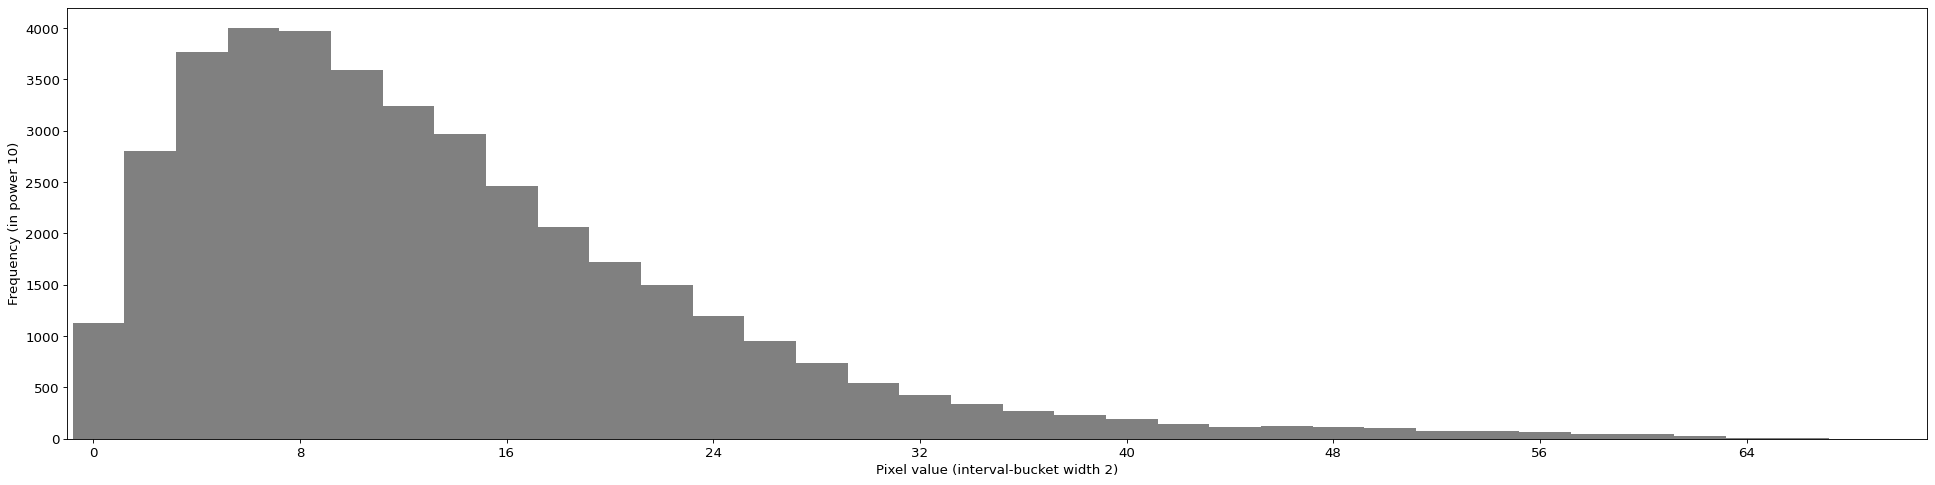

In [ ]:
region = D4_geometry
dem = ee.Image('CGIAR/SRTM90_V4')
ee_image = ee.Terrain.slope(dem)

histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        color= 'gray',
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=12)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='both', labelsize=12)

    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

plt.savefig("Slope_hist_R4.jpg", format="jpg", dpi=600)

SRTM_Slope_df_R4 = pd.DataFrame()
SRTM_Slope_df_R4['R4_x'] = x
SRTM_Slope_df_R4['R4_y'] = y

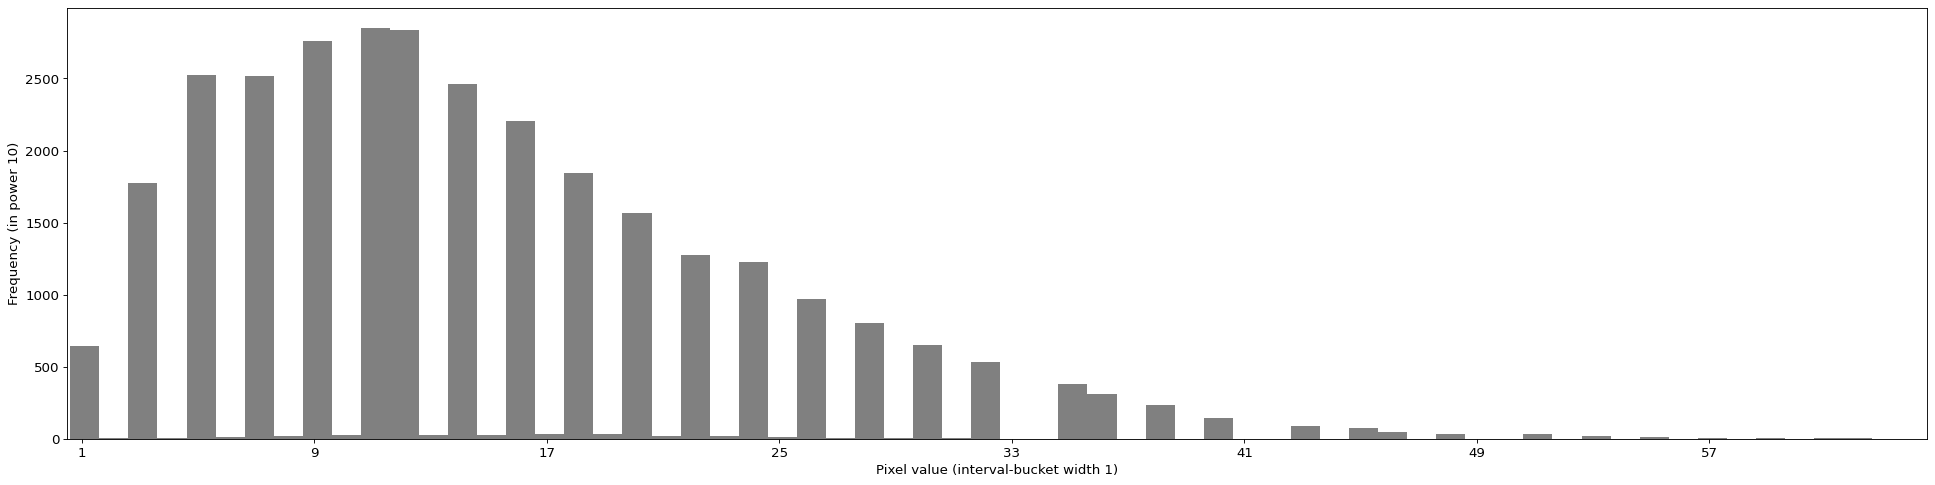

In [ ]:
region = D5_geometry
dem = ee.Image('CGIAR/SRTM90_V4')
ee_image = ee.Terrain.slope(dem)

histogramDictionary = ee_image.reduceRegion(**{
  'reducer': ee.Reducer.histogram(50),
  'geometry': region,
  #'scale': 30,
  #'maxPixels': 1e19
})
# print(histogramDictionary.getInfo())

histogram = histogramDictionary.getInfo()
bands = list(histogram.keys())
#bands


for bnd in bands:
    # plot a bar chart

    y=histogram[bnd]['histogram']
    x=[]
    for i in range(len(y)):
        x.append(histogram[bnd]['bucketMin']+i*histogram[bnd]['bucketWidth'])
    data = pd.DataFrame({'x':x,
                             'y':y})

    # Draw Plot
    fig, ax = plt.subplots(figsize=(30, 7), dpi=80)

    sns.barplot(
        data= data,
        color= 'gray',
        x= 'x',
        y= 'y',
        ax=ax
    )
    # For every axis, set the x and y major locator
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


    # Adjust width gap to zero
    for patch in ax.patches:
        current_height = patch.get_width()
        patch.set_width(1)
        patch.set_y(patch.get_y() + current_height - 1)

    # figure label and title
    #plt.title('Histogram for Band: {}'.format(bnd), fontsize=18)
    plt.ylabel('Frequency (in power 10)', fontsize=12)
    plt.xlabel('Pixel value (interval-bucket width {})'.format(histogram[bnd]['bucketWidth']), fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='both', labelsize=12)

    # save the fihure as JPG file
    #fig.savefig('figure/fig-{}.jpg'.format(bnd))

plt.savefig("Slope_hist_R5.jpg", format="jpg", dpi=600)

SRTM_Slope_df_R5 = pd.DataFrame()
SRTM_Slope_df_R5['R5_x'] = x
SRTM_Slope_df_R5['R5_y'] = y

<Axes: xlabel='test_x'>

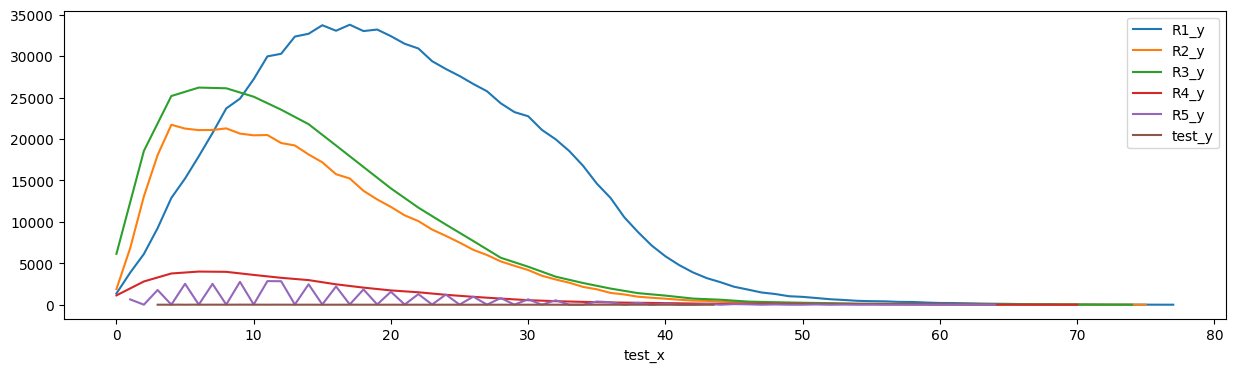

In [ ]:
ax = SRTM_Slope_df_R1.plot(x = 'R1_x', y= 'R1_y', figsize=(15, 4))
SRTM_Slope_df_R2.plot(ax=ax, x = 'R2_x', y= 'R2_y', figsize=(15, 4))
SRTM_Slope_df_R3.plot(ax=ax, x = 'R3_x', y= 'R3_y', figsize=(15, 4))
SRTM_Slope_df_R4.plot(ax=ax, x = 'R4_x', y= 'R4_y', figsize=(15, 4))
SRTM_Slope_df_R5.plot(ax=ax, x = 'R5_x', y= 'R5_y', figsize=(15, 4))
SRTM_Slope_df_test.plot(ax=ax, x = 'test_x', y= 'test_y', figsize=(15, 4))


In [ ]:
SRTM_Slope_df_R11 = SRTM_Slope_df_R1
SRTM_Slope_df_R22 = SRTM_Slope_df_R2
SRTM_Slope_df_R33 = SRTM_Slope_df_R3
SRTM_Slope_df_R44 = SRTM_Slope_df_R4
SRTM_Slope_df_R55 = SRTM_Slope_df_R5
SRTM_Slope_df_testt = SRTM_Slope_df_test

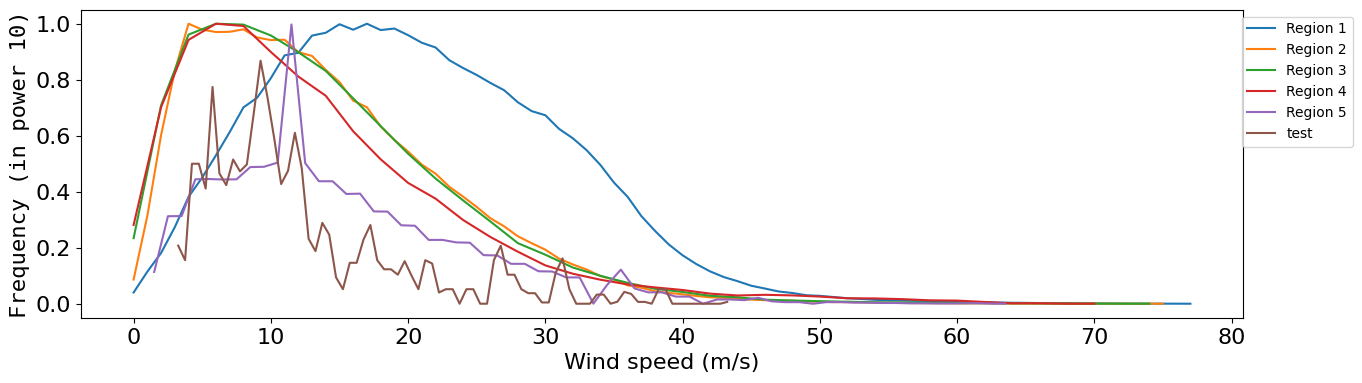

In [ ]:
SRTM_Slope_df_R1 = SRTM_Slope_df_R11
SRTM_Slope_df_R2 = SRTM_Slope_df_R22
SRTM_Slope_df_R3 = SRTM_Slope_df_R33
SRTM_Slope_df_R4 = SRTM_Slope_df_R44
SRTM_Slope_df_R5 = SRTM_Slope_df_R55
SRTM_Slope_df_test = SRTM_Slope_df_testt


SRTM_Slope_df_R1['R1_y'] = SRTM_Slope_df_R1['R1_y'] /SRTM_Slope_df_R1['R1_y'].abs().max()

SRTM_Slope_df_R2['R2_y'] = SRTM_Slope_df_R2['R2_y'] /SRTM_Slope_df_R2['R2_y'].abs().max()

SRTM_Slope_df_R3['R3_y'] = SRTM_Slope_df_R3['R3_y'] /SRTM_Slope_df_R3['R3_y'].abs().max()

SRTM_Slope_df_R4['R4_y'] = SRTM_Slope_df_R4['R4_y'] /SRTM_Slope_df_R4['R4_y'].abs().max()

SRTM_Slope_df_R5['R5_y'] = SRTM_Slope_df_R5['R5_y'] /SRTM_Slope_df_R5['R5_y'].abs().max()
SRTM_Slope_df_R5 = SRTM_Slope_df_R5.rolling(window=2).mean()

SRTM_Slope_df_test['test_y'] = SRTM_Slope_df_test['test_y'] /SRTM_Slope_df_test['test_y'].abs().max()
SRTM_Slope_df_test = SRTM_Slope_df_test.rolling(window=2).mean()


ax = SRTM_Slope_df_R1.plot(x = 'R1_x', y= 'R1_y', figsize=(15, 4))
SRTM_Slope_df_R2.plot(ax=ax, x = 'R2_x', y= 'R2_y', figsize=(15, 4))
SRTM_Slope_df_R3.plot(ax=ax, x = 'R3_x', y= 'R3_y', figsize=(15, 4))
SRTM_Slope_df_R4.plot(ax=ax, x = 'R4_x', y= 'R4_y', figsize=(15, 4))
SRTM_Slope_df_R5.plot(ax=ax, x = 'R5_x', y= 'R5_y', figsize=(15, 4))
SRTM_Slope_df_test.plot(ax=ax, x = 'test_x', y= 'test_y', figsize=(15, 4))


plt.legend(['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5', 'test'], loc='upper right', bbox_to_anchor=(1.1,1))

font = {'fontname':'monospace'}


plt.ylabel('Frequency (in power 10)', **font,  fontsize=16)
plt.xlabel("Wind speed (m/s)", fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='both', labelsize=16)





plt.savefig("normalized_slope.jpg", format="jpg", dpi=600)

plt.show()